## Importing libs

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import gdown
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
!pip install rdkit
from rdkit import Chem
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence



### Downloading the dataset

In [12]:
!git clone https://github.com/AmirJodeiry2000/Deep_Learning_SUT_Fall_2023.git Smiles_Chemical_Model


fatal: destination path 'Smiles_Chemical_Model' already exists and is not an empty directory.


In [17]:
from google.colab import files
uploaded = files.upload()

Saving BBBP.csv to BBBP.csv


### Just to see the output of Smile format

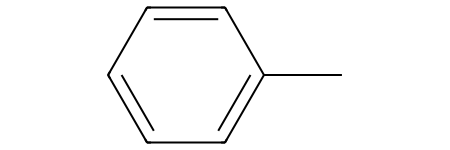

In [ ]:
Chem.MolFromSmiles('Cc1ccccc1')

### Here we build the dataframe of the input dataset

In [18]:
output_file = 'BBBP.csv'

df = pd.read_csv(output_file)
df.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


# analyzing the chain length

### Here using Chem module from rdkit, which has been developed for this purpose, we can extract the distribution of smile chain lenght

[09:29:56] Explicit valence for atom # 1 N, 4, is greater than permitted
[09:29:56] WARNING: not removing hydrogen atom without neighbors
[09:29:56] WARNING: not removing hydrogen atom without neighbors
[09:29:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[09:29:56] WARNING: not removing hydrogen atom without neighbors
[09:29:56] WARNING: not removing hydrogen atom without neighbors
[09:29:56] WARNING: not removing hydrogen atom without neighbors
[09:29:56] WARNING: not removing hydrogen atom without neighbors
[09:29:56] WARNING: not removing hydrogen atom without neighbors
[09:29:56] WARNING: not removing hydrogen atom without neighbors
[09:29:56] WARNING: not removing hydrogen atom without neighbors
[09:29:56] WARNING: not removing hydrogen atom without neighbors
[09:29:56] WARNING: not removing hydrogen atom without neighbors
[09:29:56] WARNING: not removing hydrogen atom without neighbors
[09:29:56] WARNING: not removing hydrogen atom without neighbors
[09:29:56

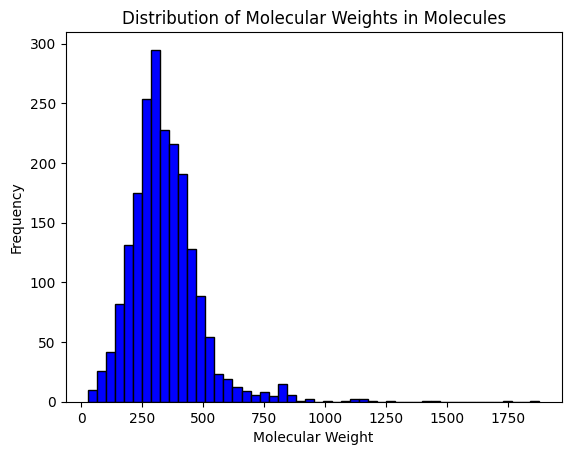

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt

molecular_weights = df['smiles'].apply(lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)) if Chem.MolFromSmiles(x) is not None else None)

plt.hist(molecular_weights.dropna(), bins=50, color='blue', edgecolor='black')
plt.xlabel('Molecular Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Molecular Weights in Molecules')
plt.show()


### *** Guidance
### The distribution of chain lengths in the molecular formulas appears to have a Normal shape as observed in the histogram. Further statistical analysis could provide insights into the underlying nature of this distribution.

# One hot encoding

## Extracting two Letter elements

In [ ]:
# refrenced to :
# https://projects.volkamerlab.org/teachopencadd/talktorials/T021_one_hot_encoding.html#SMILES-structures-and-rules

def assess_two_letter_elements(df):
    """
    Find the two letter elements in dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe which requires preprocessing.

    Returns
    -------
    two_letter_elements : list
        List with found two letter elements
    """

    # Search for unique characters in SMILES strings
    unique_chars = set(df.smiles.apply(list).sum())
    # Get upper and lower case letters only
    upper_chars = []
    lower_chars = []
    for entry in unique_chars:
        if entry.isalpha():
            if entry.isupper():
                upper_chars.append(entry)
            elif entry.islower():
                lower_chars.append(entry)
    print(f"Upper letter characters {sorted(upper_chars)}")
    print(f"Lower letter characters {sorted(lower_chars)}")

    # List of all possible periodic elements
    periodic_elements = [
        "Ac",
        "Al",
        "Am",
        "Sb",
        "Ar",
        "As",
        "At",
        "Ba",
        "Bk",
        "Be",
        "Bi",
        "Bh",
        "B",
        "Br",
        "Cd",
        "Ca",
        "Cf",
        "C",
        "Ce",
        "Cs",
        "Cl",
        "Cr",
        "Co",
        "Cn",
        "Cu",
        "Cm",
        "Ds",
        "Db",
        "Dy",
        "Es",
        "Er",
        "Eu",
        "Fm",
        "Fl",
        "F",
        "Fr",
        "Gd",
        "Ga",
        "Ge",
        "Au",
        "Hf",
        "Hs",
        "He",
        "Ho",
        "H",
        "In",
        "I",
        "Ir",
        "Fe",
        "Kr",
        "La",
        "Lr",
        "Pb",
        "Li",
        "Lv",
        "Lu",
        "Mg",
        "Mn",
        "Mt",
        "Md",
        "Hg",
        "Mo",
        "Mc",
        "Nd",
        "Ne",
        "Np",
        "Ni",
        "Nh",
        "Nb",
        "N",
        "No",
        "Og",
        "Os",
        "O",
        "Pd",
        "P",
        "Pt",
        "Pu",
        "Po",
        "K",
        "Pr",
        "Pm",
        "Pa",
        "Ra",
        "Rn",
        "Re",
        "Rh",
        "Rg",
        "Rb",
        "Ru",
        "Rf",
        "Sm",
        "Sc",
        "Sg",
        "Se",
        "Si",
        "Ag",
        "Na",
        "Sr",
        "S",
        "Ta",
        "Tc",
        "Te",
        "Ts",
        "Tb",
        "Tl",
        "Th",
        "Tm",
        "Sn",
        "Ti",
        "W",
        "U",
        "V",
        "Xe",
        "Yb",
        "Y",
        "Zn",
        "Zr",
    ]

    # The two_char_elements list contains all two letter elements
    # which can be generated by all possible combination of upper x lower characters
    # and are valid periodic elements.
    two_char_elements = []
    for upper in upper_chars:
        for lower in lower_chars:
            ch = upper + lower
            if ch in periodic_elements:
                two_char_elements.append(ch)

    # This list is then reduced to the subset of two-letter elements
    # that actually appear in the SMILES strings, specific to our data set.
    two_char_elements_smiles = set()
    for char in two_char_elements:
        if df.smiles.str.contains(char).any():
            two_char_elements_smiles.add(char)

    return two_char_elements_smiles

In [ ]:
elements_found = assess_two_letter_elements(df)
print(f"\nTwo letter elements found in the data set: {sorted(elements_found)}")

Upper letter characters ['B', 'C', 'F', 'H', 'I', 'N', 'O', 'P', 'S']
Lower letter characters ['a', 'c', 'l', 'n', 'o', 'r', 's']

Two letter elements found in the data set: ['Br', 'Ca', 'Cl', 'Cn', 'Na', 'Sc']


## Replacing the two letter elements and @@ by known element
###The new dataset will be used as the main dataset

In [ ]:
replace_dict = {"Cl": "L", "Br": "R", "@@": "Z"}


In [ ]:
def preprocessing_data(df, replacement):
    """
    Preprocess the SMILES structures in a data set.

    Parameters
    ----------
    df : pandas.DataFrame
      Dataframe which requires preprocessing.
    replacement : dict
      Dictionary with mapping for replacement.

    Returns
    -------
    df : pandas.DataFrame
        Dataframe with new processed canonical SMILES column.
    unique_char : list
        List with unique characters present in SMILES.
    """
    # Print warning if the data set has a 'Sc' element
    if df.smiles.str.contains("Sc").any():
        print(
            'Warning: "Sc" element is found in the data set, since the element is rarely found '
            "in the drugs so we are not converting  "
            'it to single letter element, instead considering "S" '
            'and "c" as separate elements. '
        )

    # Create a new column having processed canonical SMILES
    df["processed_smiles"] = df["smiles"].copy()

    # Replace the two letter elements found with one character
    for pattern, repl in replacement.items():
        df["processed_smiles"] = df["processed_smiles"].str.replace(
            pattern, repl
        )

    unique_char = set(df.processed_smiles.apply(list).sum())
    return df, unique_char

In [ ]:
df, unique_char = preprocessing_data(df, replace_dict)
df.head(3)

,num,name,p_np,smiles,processed_smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,[L].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCL)CCL
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...


### All unique Chars

In [ ]:
print(f"All unique characters found in the preprocessed data set:\n{sorted(unique_char)}")


All unique characters found in the preprocessed data set:
['#', '%', '(', ')', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '@', 'B', 'C', 'F', 'H', 'I', 'L', 'N', 'O', 'P', 'R', 'S', 'Z', '[', '\\', ']', 'a', 'c', 'n', 'o', 's']


## The longest and the shortest size string

In [ ]:
# Index of the longest SMILES string
longest_smiles = max(df["smiles"], key=len)
longest_smiles_index = df.smiles[df.smiles == longest_smiles].index.tolist()
print(f"Longest SMILES: {longest_smiles}")
print(f"Contains {len(longest_smiles)} characters, index in dataframe: {longest_smiles_index[0]}.")
smiles_maxlen = len(longest_smiles)

Longest SMILES: CCC(C)[C@H]1O[C@]2(CC[C@@H]1C)CC3C[C@@H](C\C=C(C)\[C@@H](O[C@H]4C[C@H](OC)[C@@H](OC5C[C@H](OC)[C@@H](O)[C@H](C)O5)[C@H](C)O4)[C@@H](C)/C=C/C=C/6CO[C@@H]7[C@H](O)C(=C[C@@H](C(=O)O3)[C@]67O)C)O2.CO[C@H]8CC(O[C@@H](C)[C@@H]8O)O[C@H]9[C@H](C)O[C@H](C[C@@H]9OC)O[C@H]/%10[C@@H](C)/C=C/C=C/%11CO[C@@H]%12[C@H](O)C(=C[C@@H](C(=O)OC%13C[C@@H](C\C=C%10C)O[C@@]%14(CC[C@H](C)[C@H](O%14)C(C)C)C%13)[C@]%11%12O)C
Contains 400 characters, index in dataframe: 826.


In [ ]:
# Index of the shortest SMILES string
shortest_smiles = min(df["smiles"], key=len)
shortest_smiles_index = df.smiles[df.smiles == shortest_smiles].index.tolist()
print(f"Shortest SMILES: {shortest_smiles}")
print(
    f"Contains {len(shortest_smiles)} characters, index in dataframe: {shortest_smiles_index[0]}."
)

Shortest SMILES: CCO
Contains 3 characters, index in dataframe: 454.


## Main OneHot encoding
### 400 max length
### 40 unique char
### Final size : 40*400

In [ ]:
def smiles_encoder(smiles, max_len, unique_char):
    """
    Function defined using all unique characters in our
    processed canonical SMILES structures created
    with the preprocessing_data function.

    Parameters
    ----------
    smiles : str
         SMILES of a molecule in string format.
    unique_char : list
         List of unique characters in the string data set.
    max_len : int
         Maximum length of the SMILES string.

    Returns
    -------
    smiles_matrix : numpy.ndarray
         One-hot encoded matrix of fixed shape
         (unique char in smiles, max SMILES length).
    """
    # create dictionary of the unique char data set
    smi2index = {char: index for index, char in enumerate(unique_char)}
    # one-hot encoding
    # zero padding to max_len
    smiles_matrix = np.zeros((len(unique_char), max_len))
    for index, char in enumerate(smiles):
        smiles_matrix[smi2index[char], index] = 1
    return smiles_matrix
# Apply the function to the processed  SMILES strings
df["unique_char_ohe_matrix"] = df["processed_smiles"].apply(
    smiles_encoder, max_len=smiles_maxlen, unique_char=unique_char
)
df.unique_char_ohe_matrix[10].shape

(40, 400)

## Building FC layer

In [ ]:
import torch.nn as nn

class Binary_Classifier(nn.Module):
    def __init__(self, input_size):
        super(Binary_Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


## Spliting to train and validation

In [ ]:

x = torch.tensor(df.unique_char_ohe_matrix)
y = torch.tensor(df['p_np'].values).float().unsqueeze(1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)



train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

<ipython-input-15-7af6ddef9647>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  x = torch.tensor(df.unique_char_ohe_matrix)


In [ ]:
df.head()

,num,name,p_np,smiles,processed_smiles,unique_char_ohe_matrix,smiles_length
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,[L].CC(C)NCC(O)COc1cccc2ccccc12,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",32
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCL)CCL,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",40
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",50
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",32
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,Cc1onc(c2ccccc2L)c1C(=O)N[C@H]3[C@H]4SC(C)(C)[...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",66


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
model_FC = Binary_Classifier(40*400)
model_FC.to(device)
criterion_FC = nn.BCELoss()
optimizer_FC = optim.Adam(model_FC.parameters(), lr=0.001)



## Train and acc

In [ ]:
def train_test(model, criterion, optimizer, num_epochs):
    model.to(device)

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device).float(), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            predicted_train = (outputs > 0.5).float()
            correct_train += (predicted_train == labels).sum().item()
            total_train += labels.size(0)

        average_loss = total_loss / len(train_dataloader)
        train_accuracy = correct_train / total_train

        train_losses.append(average_loss)
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_loss:.4f}, Train Acc: {train_accuracy:.4f}")

        model.eval()
        with torch.no_grad():
            correct_test = 0
            total_test = 0
            test_loss = 0.0

            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device).float(), labels.to(device).float()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                predicted_test = (outputs > 0.5).float()
                correct_test += (predicted_test == labels).sum().item()
                total_test += labels.size(0)

            average_test_loss = test_loss / len(test_dataloader)
            test_accuracy = correct_test / total_test

            test_losses.append(average_test_loss)
            test_accuracies.append(test_accuracy)

            print(f"Test Loss: {average_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    return train_losses, train_accuracies, test_losses, test_accuracies



In [ ]:
train_losses, train_accuracies, test_losses, test_accuracies = train_test(model_FC, criterion_FC, optimizer_FC, 20)

Epoch 1/20, Train Loss: 0.6410, Train Acc: 0.7555
Test Loss: 0.5919, Test Acc: 0.7756
Epoch 2/20, Train Loss: 0.5554, Train Acc: 0.7756
Test Loss: 0.5296, Test Acc: 0.7780
Epoch 3/20, Train Loss: 0.5016, Train Acc: 0.7823
Test Loss: 0.4922, Test Acc: 0.7829
Epoch 4/20, Train Loss: 0.4636, Train Acc: 0.7902
Test Loss: 0.4658, Test Acc: 0.7878
Epoch 5/20, Train Loss: 0.4361, Train Acc: 0.8055
Test Loss: 0.4459, Test Acc: 0.7976
Epoch 6/20, Train Loss: 0.4114, Train Acc: 0.8207
Test Loss: 0.4297, Test Acc: 0.8073
Epoch 7/20, Train Loss: 0.3924, Train Acc: 0.8323
Test Loss: 0.4166, Test Acc: 0.8146
Epoch 8/20, Train Loss: 0.3750, Train Acc: 0.8439
Test Loss: 0.4054, Test Acc: 0.8220
Epoch 9/20, Train Loss: 0.3606, Train Acc: 0.8555
Test Loss: 0.3954, Test Acc: 0.8293
Epoch 10/20, Train Loss: 0.3475, Train Acc: 0.8646
Test Loss: 0.3868, Test Acc: 0.8317
Epoch 11/20, Train Loss: 0.3354, Train Acc: 0.8695
Test Loss: 0.3790, Test Acc: 0.8439
Epoch 12/20, Train Loss: 0.3250, Train Acc: 0.8726
T

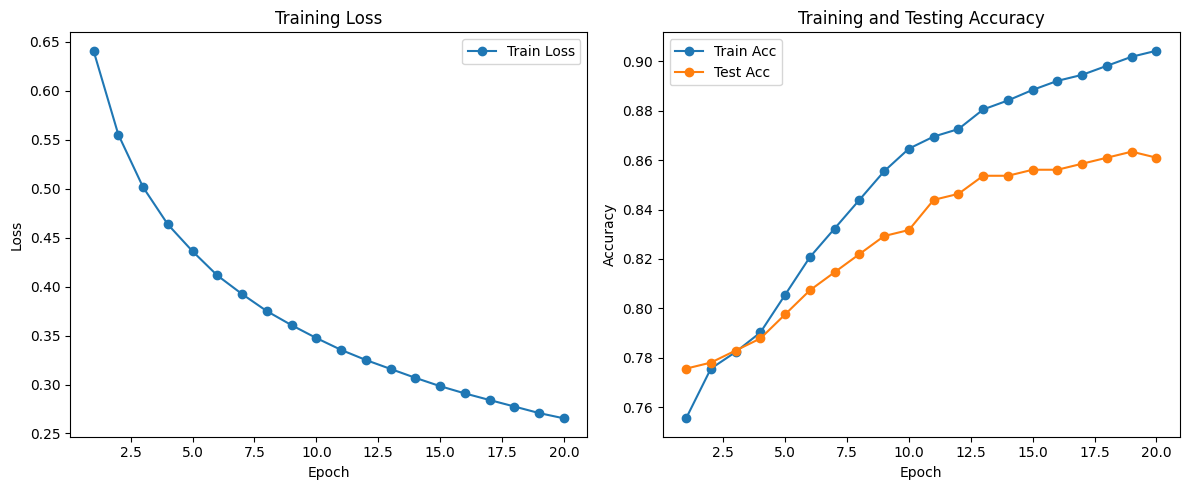

In [ ]:
import matplotlib.pyplot as plt

def plot_results(train_losses, train_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Acc', marker='o')
    plt.plot(epochs, test_accuracies, label='Test Acc', marker='o')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_results(train_losses, train_accuracies, test_accuracies)


## Coding LSTM

In [ ]:
class LSTM_Module(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_Module, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x


In [ ]:
input_size = 400
hidden_size = 256
num_layers = 2
model_LSTM = LSTM_Module(input_size, hidden_size, num_layers)
criterion_LSTM = nn.BCELoss()
optimizer_LSTM = optim.Adam(model_LSTM.parameters(), lr=0.001)
model_LSTM.to(device)

LSTM_Module(
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
train_losses, train_accuracies, test_losses, test_accuracies = train_test(model_LSTM, criterion_LSTM, optimizer_LSTM, num_epochs=20)


Epoch 1/20, Train Loss: 0.6083, Train Acc: 0.7195
Test Loss: 0.5797, Test Acc: 0.7683
Epoch 2/20, Train Loss: 0.5570, Train Acc: 0.7634
Test Loss: 0.5337, Test Acc: 0.7683
Epoch 3/20, Train Loss: 0.5283, Train Acc: 0.7634
Test Loss: 0.5153, Test Acc: 0.7732
Epoch 4/20, Train Loss: 0.4817, Train Acc: 0.7774
Test Loss: 0.4821, Test Acc: 0.8000
Epoch 5/20, Train Loss: 0.4223, Train Acc: 0.8134
Test Loss: 0.4269, Test Acc: 0.8073
Epoch 6/20, Train Loss: 0.3805, Train Acc: 0.8287
Test Loss: 0.4103, Test Acc: 0.8122
Epoch 7/20, Train Loss: 0.3366, Train Acc: 0.8457
Test Loss: 0.3930, Test Acc: 0.7976
Epoch 8/20, Train Loss: 0.3121, Train Acc: 0.8543
Test Loss: 0.3970, Test Acc: 0.8024
Epoch 9/20, Train Loss: 0.2900, Train Acc: 0.8774
Test Loss: 0.3740, Test Acc: 0.8220
Epoch 10/20, Train Loss: 0.2765, Train Acc: 0.8811
Test Loss: 0.4137, Test Acc: 0.8049
Epoch 11/20, Train Loss: 0.2551, Train Acc: 0.8902
Test Loss: 0.4151, Test Acc: 0.7976
Epoch 12/20, Train Loss: 0.2707, Train Acc: 0.8823
T

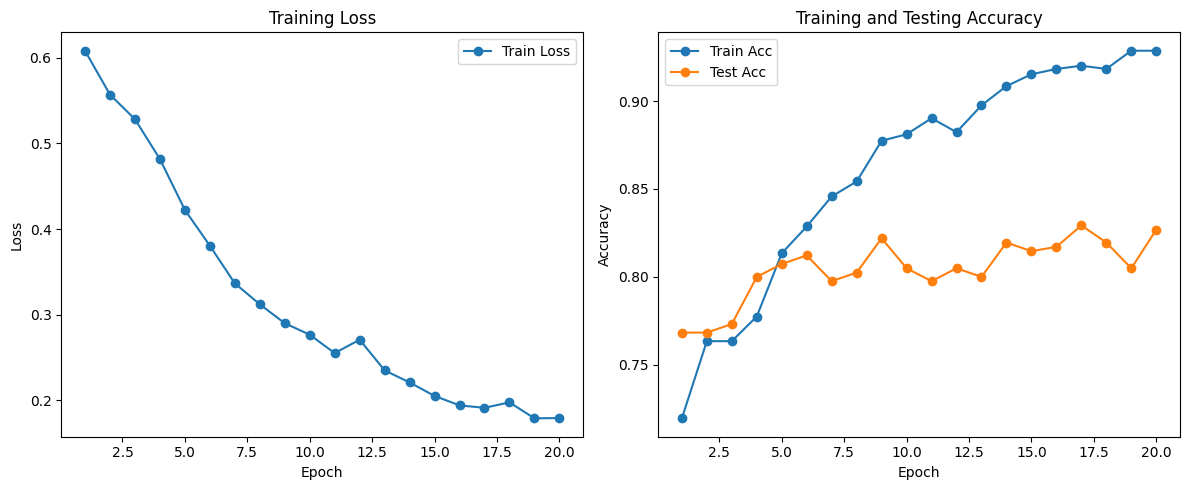

In [ ]:

# Plot the results
plot_results(train_losses, train_accuracies, test_accuracies)


## Coding BiLSTM

In [ ]:
class BiLSTM_Module(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(BiLSTM_Module, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(2*hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        bilstm_out, _ = self.bilstm(x)
        x = bilstm_out[:, -1, :]
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x


In [ ]:
input_size = 400
hidden_size = 256
num_layers = 2
model_BiLSTM = BiLSTM_Module(input_size, hidden_size, num_layers)
criterion_BiLSTM = nn.BCELoss()
optimizer_BiLSTM = optim.Adam(model_BiLSTM.parameters(), lr=0.005)
model_LSTM.to(device)

LSTM_Module(
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
train_losses, train_accuracies, test_losses, test_accuracies = train_test(model_BiLSTM, criterion_BiLSTM, optimizer_BiLSTM, num_epochs=20)


Epoch 1/20, Train Loss: 0.6062, Train Acc: 0.7128
Test Loss: 0.5219, Test Acc: 0.7805
Epoch 2/20, Train Loss: 0.5463, Train Acc: 0.7579
Test Loss: 0.5401, Test Acc: 0.7683
Epoch 3/20, Train Loss: 0.5407, Train Acc: 0.7634
Test Loss: 0.5421, Test Acc: 0.7683
Epoch 4/20, Train Loss: 0.5538, Train Acc: 0.7457
Test Loss: 0.5150, Test Acc: 0.7683
Epoch 5/20, Train Loss: 0.5102, Train Acc: 0.7738
Test Loss: 0.4960, Test Acc: 0.7659
Epoch 6/20, Train Loss: 0.4645, Train Acc: 0.7835
Test Loss: 0.4426, Test Acc: 0.8146
Epoch 7/20, Train Loss: 0.3598, Train Acc: 0.8659
Test Loss: 0.4134, Test Acc: 0.8390
Epoch 8/20, Train Loss: 0.3040, Train Acc: 0.8713
Test Loss: 0.3688, Test Acc: 0.8537
Epoch 9/20, Train Loss: 0.2674, Train Acc: 0.8835
Test Loss: 0.3559, Test Acc: 0.8415
Epoch 10/20, Train Loss: 0.2380, Train Acc: 0.9018
Test Loss: 0.3522, Test Acc: 0.8561
Epoch 11/20, Train Loss: 0.2125, Train Acc: 0.9128
Test Loss: 0.3538, Test Acc: 0.8561
Epoch 12/20, Train Loss: 0.2483, Train Acc: 0.8988
T

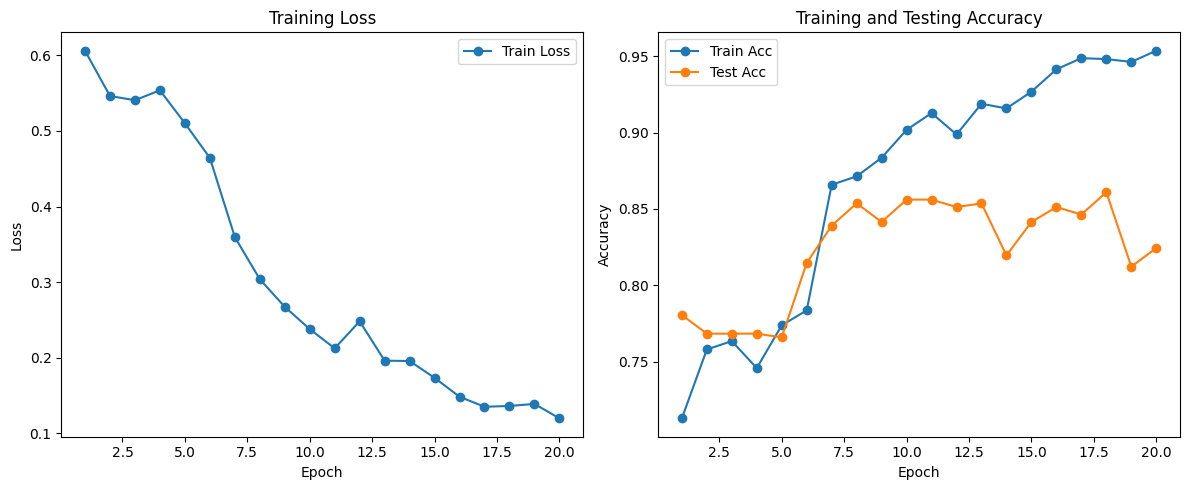

In [ ]:
plot_results(train_losses, train_accuracies, test_accuracies)


## Coding Kfold Cross validation

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_losses, all_train_accuracies, all_test_losses, all_test_accuracies = [], [], [], []

for fold, (train_index, test_index) in enumerate(kf.split(x, y)):
    print(f'Fold {fold + 1}/{kf.n_splits}')

    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    model = LSTM_Module(input_size, hidden_size, num_layers)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses, train_accuracies, test_losses, test_accuracies = train_test(model, criterion, optimizer, num_epochs=30)

    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_test_losses.append(test_losses)
    all_test_accuracies.append(test_accuracies)

mean_train_loss = torch.tensor(all_train_losses).mean(dim=0)
mean_train_acc = torch.tensor(all_train_accuracies).mean(dim=0)
mean_test_loss = torch.tensor(all_test_losses).mean(dim=0)
mean_test_acc = torch.tensor(all_test_accuracies).mean(dim=0)



Fold 1/5
Epoch 1/30, Train Loss: 0.5804, Train Acc: 0.7293
Test Loss: 0.4758, Test Acc: 0.7683
Epoch 2/30, Train Loss: 0.5327, Train Acc: 0.7634
Test Loss: 0.4470, Test Acc: 0.7683
Epoch 3/30, Train Loss: 0.4965, Train Acc: 0.7652
Test Loss: 0.4115, Test Acc: 0.7854
Epoch 4/30, Train Loss: 0.4483, Train Acc: 0.8098
Test Loss: 0.3731, Test Acc: 0.8195
Epoch 5/30, Train Loss: 0.3832, Train Acc: 0.8409
Test Loss: 0.3936, Test Acc: 0.8000
Epoch 6/30, Train Loss: 0.3612, Train Acc: 0.8372
Test Loss: 0.3369, Test Acc: 0.8415
Epoch 7/30, Train Loss: 0.3341, Train Acc: 0.8640
Test Loss: 0.3181, Test Acc: 0.8366
Epoch 8/30, Train Loss: 0.2832, Train Acc: 0.8854
Test Loss: 0.2938, Test Acc: 0.8341
Epoch 9/30, Train Loss: 0.2621, Train Acc: 0.8896
Test Loss: 0.3470, Test Acc: 0.8000
Epoch 10/30, Train Loss: 0.2708, Train Acc: 0.8951
Test Loss: 0.3520, Test Acc: 0.8488
Epoch 11/30, Train Loss: 0.2480, Train Acc: 0.9000
Test Loss: 0.2950, Test Acc: 0.8439
Epoch 12/30, Train Loss: 0.2289, Train Acc:

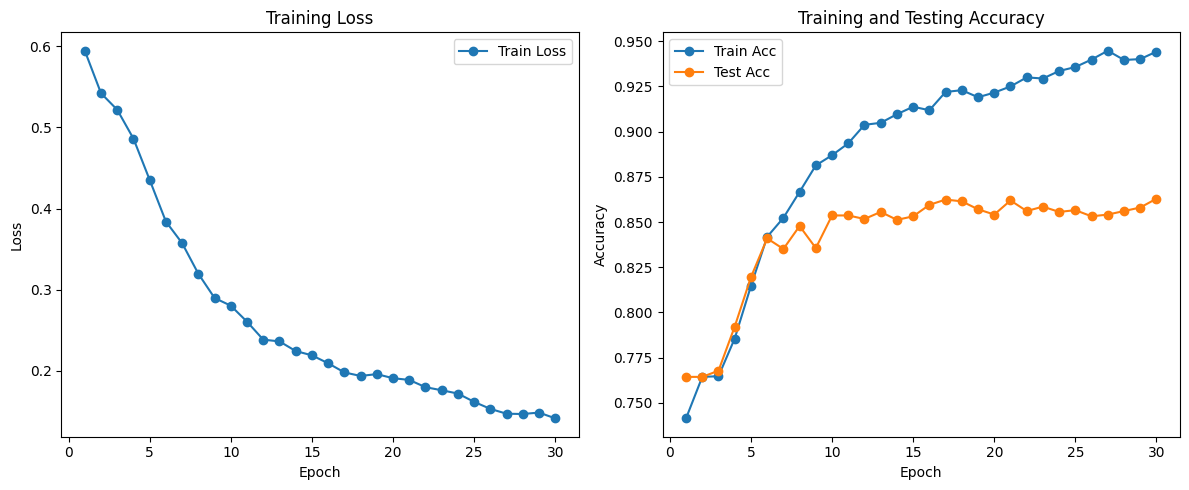

In [ ]:
plot_results(mean_train_loss.tolist(), mean_train_acc.tolist(), mean_test_acc.tolist())


## bining the data
#### First, we add a smiles length column to your main data frame, which gives the length of each. next
### so now have another x test.
### we come from the data frame and with the help of x test you find those rows of the data frame that are in x test. That is, the size of the data frame is limited to x test. I mean rows
### Then using command pd.qcut we continue.
###we give it the number of bins and that column smiles length, it will divide it to 10 bins. If you plot between the 10, you will see that it is divided into 10 parts, each of which has almost the same amount of data.
###After that, you can easily make a loader for them.

In [ ]:
b = [i for i, c in enumerate(df['unique_char_ohe_matrix']) for a in x_test if torch.equal(torch.tensor(c), a)]


410

In [ ]:
df['smiles_length'] = df['smiles'].apply(len)

df_test = pd.DataFrame(columns=df.columns)

for index in b:
    df_test = df_test.append(df.loc[index], ignore_index=True)


<ipython-input-163-aadc50709554>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.loc[index], ignore_index=True)


,num,name,p_np,smiles,processed_smiles,unique_char_ohe_matrix,smiles_length,bin
0,24,nadolol,1,CC(C)(C)NCC(O)COc1cccc2C[C@@H](O)[C@@H](O)Cc12,CC(C)(C)NCC(O)COc1cccc2C[CZH](O)[CZH](O)Cc12,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",46,5
1,26,12,0,CCNC(=NC#N)NCCSCc1c(cccn1)Br,CCNC(=NC#N)NCCSCc1c(cccn1)R,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",28,1
2,30,piperacillin,1,O.CCN1CCN(C(=O)N[C@@H](C(=O)N[C@H]2[C@H]3SC(C)...,O.CCN1CCN(C(=O)N[CZH](C(=O)N[C@H]2[C@H]3SC(C)(...,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",88,9
3,31,Pentobarbital,1,CCCC(C)C1(CC)C(=O)NC(=O)NC1=O,CCCC(C)C1(CC)C(=O)NC(=O)NC1=O,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",29,1
4,33,compound 40,1,c1ccc(C(NCCCOc2cc(CN3CCCCC3)ccc2)=O)cc1,c1ccc(C(NCCCOc2cc(CN3CCCCC3)ccc2)=O)cc1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",39,3
...,...,...,...,...,...,...,...,...
405,2033,tropapride,1,[C@H]13N([C@H](CC(C1)NC(C2=CC=CC(=C2OC)OC)=O)C...,[C@H]13N([C@H](CC(C1)NC(C2=CC=CC(=C2OC)OC)=O)C...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",61,7
406,2043,xanomeline,1,C(OC1=NSN=C1C2=CCCN(C2)C)CCCCC,C(OC1=NSN=C1C2=CCCN(C2)C)CCCCC,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",30,1
407,2046,zomebazam,1,C3=C(N2C1=C([N](C)N=C1C)N(C(=O)CC2=O)C)C=CC=C3,C3=C(N2C1=C([N](C)N=C1C)N(C(=O)CC2=O)C)C=CC=C3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",46,5
408,2048,nitrous-oxide,1,[N+](=[N-])=O,[N+](=[N-])=O,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",13,0


In [ ]:
def test(model, criterion, optimizer,test_dataloader, num_epochs):
    model.to(device)


    test_accuracies = []

    model.eval()
    with torch.no_grad():
        correct_test = 0
        total_test = 0

        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device).float(), labels.to(device).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            predicted_test = (outputs > 0.5).float()
            correct_test += (predicted_test == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = correct_test / total_test

    test_accuracies.append(test_accuracy)

    print(f"Test Acc: {test_accuracy:.4f}")

    return test_accuracies



In [ ]:

binwise_results = {'Sequential': {}, 'Baseline': {}}

for bin_number in range(10):
    print('bin_num = ' + str(bin_number + 1))
    bin_data = df_test[df_test['bin'] == bin_number]

    x_bin = torch.tensor(bin_data.unique_char_ohe_matrix.tolist(), dtype=torch.float32)
    y_bin = torch.tensor(bin_data['p_np'].values.astype(np.float32)).unsqueeze(1)

    bin_dataset = TensorDataset(x_bin, y_bin)
    bin_dataloader = DataLoader(bin_dataset, batch_size=128, shuffle=False)



    print('Sequential Model : ')
    sequential_test_accuracies = test(model_LSTM, criterion_LSTM,optimizer_LSTM,bin_dataloader, num_epochs=10)
    binwise_results['Sequential'][bin_number] = {
        'TestAccuracies': sequential_test_accuracies
    }



    print('BaseLine Model : ')
    baseline_test_accuracies = test(model_FC, criterion_FC, optimizer_FC, bin_dataloader,num_epochs=10)
    binwise_results['Baseline'][bin_number] = {
        'TestAccuracies': baseline_test_accuracies
    }


bin_num = 1
Sequential Model : 
Test Acc: 0.7895
BaseLine Model : 
Test Acc: 0.7632
bin_num = 2
Sequential Model : 
Test Acc: 0.7778
BaseLine Model : 
Test Acc: 0.7778
bin_num = 3
Sequential Model : 
Test Acc: 0.8864
BaseLine Model : 
Test Acc: 0.8864
bin_num = 4
Sequential Model : 
Test Acc: 0.8909
BaseLine Model : 
Test Acc: 0.8727
bin_num = 5
Sequential Model : 
Test Acc: 0.9000
BaseLine Model : 
Test Acc: 0.9250
bin_num = 6
Sequential Model : 
Test Acc: 0.7429
BaseLine Model : 
Test Acc: 0.8571
bin_num = 7
Sequential Model : 
Test Acc: 0.7838
BaseLine Model : 
Test Acc: 0.8378
bin_num = 8
Sequential Model : 
Test Acc: 0.8444
BaseLine Model : 
Test Acc: 0.9333
bin_num = 9
Sequential Model : 
Test Acc: 0.8182
BaseLine Model : 
Test Acc: 0.8485
bin_num = 10
Sequential Model : 
Test Acc: 0.7872
BaseLine Model : 
Test Acc: 0.8723


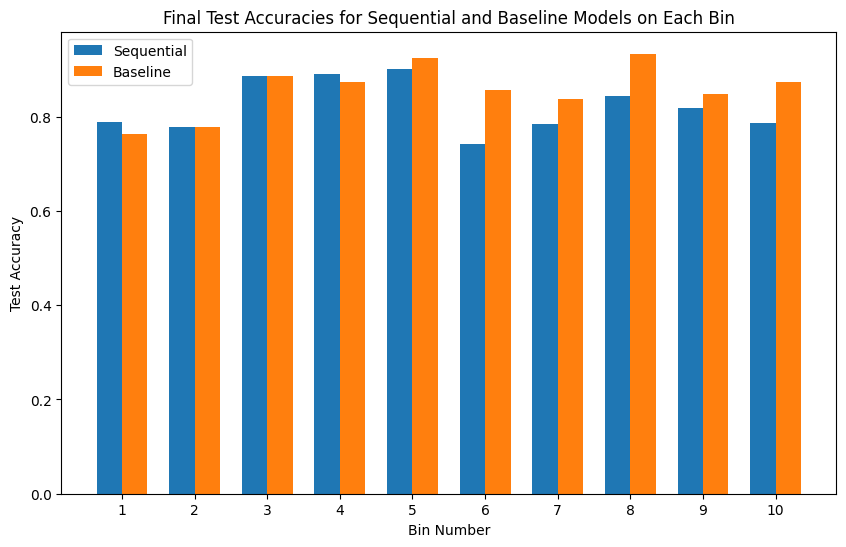

In [ ]:
import matplotlib.pyplot as plt

# Assuming binwise_results is already populated

# Extract final test accuracies for Sequential model
sequential_final_test_accuracies = [binwise_results['Sequential'][bin_number]['TestAccuracies'][-1] for bin_number in range(10)]

# Extract final test accuracies for Baseline model
baseline_final_test_accuracies = [binwise_results['Baseline'][bin_number]['TestAccuracies'][-1] for bin_number in range(10)]

# Plot bar chart for Sequential and Baseline final test accuracies
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(1, 11)

plt.bar(index, sequential_final_test_accuracies, width=bar_width, label='Sequential')
plt.bar([i + bar_width for i in index], baseline_final_test_accuracies, width=bar_width, label='Baseline')

plt.xlabel('Bin Number')
plt.ylabel('Test Accuracy')
plt.title('Final Test Accuracies for Sequential and Baseline Models on Each Bin')
plt.xticks([i + bar_width/2 for i in index], index)
plt.legend()
plt.show()


### It seems that the Seq model has better performance on lower bins, and the BaseLine model on higher bins.